In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

In [ ]:
#default_exp vision.dino

# DINO

> DINO: [Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/pdf/2104.14294.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.models.vision_transformer import *

## Algorithm

#### DINO

![DINO Framework](images/dino.png)

**Abstract**: In this paper, we question if self-supervised learning provides
new properties to Vision Transformer (ViT) [18] that
stand out compared to convolutional networks (convnets).
Beyond the fact that adapting self-supervised methods to this
architecture works particularly well, we make the following
observations: first, self-supervised ViT features contain
explicit information about the semantic segmentation of an
image, which does not emerge as clearly with supervised
ViTs, nor with convnets. Second, these features are also excellent
k-NN classifiers, reaching 78.3% top-1 on ImageNet
with a small ViT. Our study also underlines the importance of
momentum encoder [31], multi-crop training [10], and the
use of small patches with ViTs. We implement our findings
into a simple self-supervised method, called DINO, which
we interpret as a form of self-distillation with no labels.
We show the synergy between DINO and ViTs by achieving
80.1% top-1 on ImageNet in linear evaluation with ViT-Base.

**Own Summary**: In this paper authors show effectiveness of the combination of DINO framework and ViT based architectures such as ViT and DEIT. There is no contrastive training nor negative pairs, rather ideas such as momentum encoder and multi-crop augmention from `BYOL` and `SWAV` respectively are adapted. They use distillation with a teacher-student configuration, and avoid representation collapse by centering and sharpening target distributions generated by the teacher. 2 large views (~50%) are used as targets and all views (2 large, 4 small) are used for predictions similar to `SWAV`. Centering values and teacher parameters are updated via ema (exponential moving average).

In [ ]:
#export
class DINOHead(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.utils.weight_norm.html
    https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    '''
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [ ]:
bs = 4
x_large = [torch.randn(4,3,224,224)]*2
x_small = [torch.randn(4,3,96,96)]*4

In [ ]:
x = x_large + x_small; [xi.size() for xi in x]

[torch.Size([4, 3, 224, 224]),
 torch.Size([4, 3, 224, 224]),
 torch.Size([4, 3, 96, 96]),
 torch.Size([4, 3, 96, 96]),
 torch.Size([4, 3, 96, 96]),
 torch.Size([4, 3, 96, 96])]

In [ ]:
student_encoder = VisionTransformer(patch_size=32, embed_dim=128, depth=4, num_heads=4, mlp_ratio=4,
                          qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
teacher_encoder = VisionTransformer(patch_size=32, embed_dim=128, depth=4, num_heads=4, mlp_ratio=4,
                          qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

In [ ]:
student_encoder = MultiCropWrapper(student_encoder)
teacher_encoder = MultiCropWrapper(teacher_encoder)

In [ ]:
out_dim = 2**10; out_dim

1024

In [ ]:
student_head = DINOHead(student_encoder.encoder.embed_dim, out_dim, norm_last_layer=True)
teacher_head = DINOHead(student_encoder.encoder.embed_dim, out_dim, norm_last_layer=True)

In [ ]:
student_head

DINOHead(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=2048, bias=True)
    (1): GELU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): GELU()
    (4): Linear(in_features=2048, out_features=256, bias=True)
  )
  (last_layer): Linear(in_features=256, out_features=1024, bias=False)
)

In [ ]:
assert torch.equal(student_head.last_layer.weight, student_head.last_layer.weight_g*student_head.last_layer.weight_v)

In [ ]:
student_model = nn.Sequential(student_encoder, student_head)
teacher_model = nn.Sequential(teacher_encoder, teacher_head)

In [ ]:
teacher_model.load_state_dict(student_model.state_dict());

In [ ]:
for param_t in teacher_model.parameters(): param_t.requires_grad = False

In [ ]:
preds = student_model(x)
with torch.no_grad(): 
    targs = teacher_model(x_large)

In [ ]:
preds.shape, targs.shape

(torch.Size([24, 1024]), torch.Size([8, 1024]))

In [ ]:
bs = 4

In [ ]:
cmom, tmom = 0.999,0.999
tps,tpt = 0.4,0.4

In [ ]:
C = torch.zeros(1,out_dim)

In [ ]:
# center and sharpen
targs = F.softmax(targs - C / tpt, dim=-1)

In [ ]:
# sharpen
preds = F.log_softmax(preds / tps, dim=-1)

In [ ]:
targs.shape, preds.shape

(torch.Size([8, 1024]), torch.Size([24, 1024]))

In [ ]:
n_targs, n_preds = targs.size(0)//bs, preds.size(0)//bs

In [ ]:
targs1 = targs.view(bs, targs.size(0)//bs, -1)
preds1 = preds.view(bs, preds.size(0)//bs, -1)

In [ ]:
targs1.shape, preds1.shape

(torch.Size([4, 2, 1024]), torch.Size([4, 6, 1024]))

In [ ]:
loss = (-targs1.unsqueeze(2)*preds1.unsqueeze(1)).sum(-1).mean(0)

In [ ]:
mask = torch.ones_like(loss)

In [ ]:
mask[0,0] = 0
mask[1,1] = 0

In [ ]:
loss[mask.bool()].mean()

tensor(6.9360, grad_fn=<MeanBackward0>)

In [ ]:
targs,preds = targs.chunk(n_targs), preds.chunk(n_preds)

In [ ]:
len(targs), len(preds)

(2, 6)

In [ ]:
npairs = len(targs)*(len(preds)-1) 
loss = 0
for ti in range(len(targs)):
    for pi in range(len(preds)):
        if ti != pi:
            loss += (-targs[ti]*preds[pi]).sum(-1).mean() / npairs

In [ ]:
#export
@delegates(get_multi_aug_pipelines, but=['n', 'size', 'resize_scale'])
def get_dino_aug_pipelines(num_crops=(2,4), crop_sizes=(224,96), min_scales=(0.4,0.05), max_scales=(1.,0.4), **kwargs): 
    aug_pipelines = []
    for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
        aug_pipelines += get_multi_aug_pipelines(n=nc, size=size, resize_scale=(mins,maxs), **kwargs)
    return aug_pipelines

In [ ]:
aug_pipelines = get_dino_aug_pipelines()

In [ ]:
x = torch.randn(1,5)

In [ ]:
F.softmax(x,dim=1)

tensor([[0.3998, 0.1460, 0.1550, 0.1327, 0.1665]])

In [ ]:
F.softmax(x/0.04,dim=1)

tensor([[1.0000e+00, 1.1447e-11, 5.1287e-11, 1.0637e-12, 3.0646e-10]])

In [ ]:
F.softmax(x/0.1,dim=1)

tensor([[9.9971e-01, 4.2010e-05, 7.6538e-05, 1.6240e-05, 1.5647e-04]])

In [ ]:
warmup_teacher_temp
teacher_temp
warmup_teacher_temp_epochs
nepochs =
np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

In [ ]:
sched_lin(0.04,0.07,)

In [ ]:
2**16

65536

In [ ]:
pct = 0.3
scheds = combine_scheds([pct,1-pct], [SchedLin(0.04, 0.07), SchedNo(0.07, 0.07)])

In [ ]:
ts = [scheds(i) for i in np.linspace(0,1,1000)]

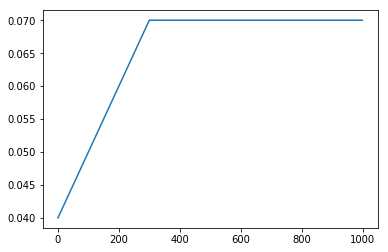

In [ ]:
plt.plot(ts)

In [ ]:
#export
class DINO(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, large_crop_ids=[0,1],
                         cmom=0.9, tmom=0.996,
                         tpt_start=0.04, tpt_warmup_pct=0.3, tpt_sched=SchedLin, tpt_end=0.07,
                         tps=0.1,
                         print_augs=False):
        """
        Refer to original repo: 
        https://github.com/facebookresearch/dino/blob/0be6e112dd579203caaa1d0f066e29ca536f76dd/main_dino.py#L41
            cmom:           Center update momentum.
            tmom:           Teacher update momentum. Set larger, e.g. 0.9995, for small batches.
            tpt_warmup:     Warm up starting temperature
            tpt_warmup_pct: Percentage of training for warmup
            tpt_sched:      Warm up scheduler, e.g. SchedLin, SchedCos, SchedExp
            tpt:            Teacher temperature after warm up. Decrease if training loss does not decrease.
                            Smaller temperature means more sharpening.
            tps:            Student temperature.
        """
        store_attr('large_crop_ids,cmom,tmom,tps')
        self.augs = aug_pipelines
        self.tpt_scheduler = combine_scheds([tpt_warmup_pct,1-tpt_warmup_pct],
                                            [tpt_sched(tpt_start,tpt_end),SchedNo(tpt_end,tpt_end)])
        if print_augs: 
            for aug in self.augs: print(aug)
    
    def before_fit(self):
        "Create teacher model as a copy of student"
        self.teacher_model = deepcopy(self.learn.model).to(self.dls.device)
        for param_t in self.teacher_model.parameters(): param_t.requires_grad = False 
        self.learn.loss_func = self.lf
        self.C = torch.zeros(1,num_features_model(self.learn.model))
        self.tpt = self.tpt_scheduler(0.)
    
    def before_train(self):    self.teacher_model.train()
    def before_validate(self): self.teacher_model.eval()
    def before_batch(self):
        "Augment multi crop views"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        x_large = [self.learn.xb[0][i] for i in self.large_crop_ids]
        self.cb = torch.cat(x_large).mean(0)
        with torch.no_grad(): self.yb = (self.teacher_model(x_large),)

            
    def _momentum_update_teacher(self):
        for param_q, param_t in zip(self.learn.model.parameters(), self.teacher_model.parameters()):
            param_t.data = param_t.data * self.tmom + param_t.data * (1. - self.tmom)
    
    
    def _momentum_update_center(self):
        self.C = self.C*self.cmom + self.cb*(1-self.cmom)
            
            
    def after_step(self):
        "Center and teacher updates"
        self._momentum_update_center()
        self._momentum_update_teacher()
        
    def after_epoch(self):
        "Update tpt at the end of each epoch"
        self.tpt = self.tpt_scheduler(self.pct_train)

        
    def lf(self, pred, *yb):
        "Multi crop cross entropy loss: -qlog(p)"
        pred = F.log_softmax(pred / self.tps, dim=-1)
        yb   = F.softmax(yb - self.C / self.tpt, dim=-1)
        
        n_targs, n_preds = yb.size(0)//bs, pred.size(0)//bs
        yb,pred = yb.chunk(n_targs), pred.chunk(n_preds)

        loss, npairs = 0, len(targs)*(len(preds)-1) 
        for ti in range(len(targs)):
            for pi in range(len(preds)):
                if ti != pi:
                    loss += (-targs[ti]*preds[pi]).sum(-1).mean() / npairs
        return loss
        
        
        
    @torch.no_grad()
    def show(self, n=1):
        xbs = self.learn.xb[0]
        idxs = np.random.choice(range(self.bs), n, False)
        images = [aug.decode(xb.to('cpu').clone()).clamp(0, 1)[i] 
                  for i in idxs
                  for xb, aug in zip(xbs, self.augs)]
        return show_batch(images[0], None, images, max_n=len(images), nrows=n)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 14 - barlow_twins.ipynb.
Converted 15 - dino.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted 70 - vision.metrics.ipynb.
Converted 90 - models.vision_transformer.ipynb.
Converted index.ipynb.
